# 尝试反向建模生成制备参数

In [1]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from torch.nn.utils.rnn import pad_sequence

In [2]:
current_directory = os.getcwd()
print(current_directory)
device=torch.device("cuda")
# 检查是否有可用的 GPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # 使用 GPU
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")  # 使用 CPU
    print("No GPU available, using CPU instead.")

/share/users/fxy/work/Constitutive_Equation/MFNN/singlefluid
Using GPU: NVIDIA GeForce RTX 3090


In [ ]:
# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# 读取 Excel 文件中的所有 sheet
url_hf = 'Data/DifferComponent_data.xlsm'
df_HF = pd.read_excel(url_hf, sheet_name=None)

# 初始化存储输入和标签的列表
inputs = []  # 存储每个 sheet 的 AngFreq 和 lossF
labels = []  # 存储每个 sheet 的 Mn1, Mn2, Mn3, Mn11, Mn22, Mn33
sequence_lengths = []  # 存储每个 sheet 的长度

# 遍历所有 sheet
for sheet_name, df in df_HF.items():
    # 移除包含 NaN 的行
    df = df.dropna()
    if sheet_name !='b4':
        continue
    # 提取 AngFreq 和 lossF 作为输入特征
    ang_freq = df['AngFreq'].values.astype(np.float32)
    loss_f = df['lossF'].values.astype(np.float32)
    
    # 对 AngFreq 进行对数化处理
    ang_freq_log = np.log10(ang_freq)  # 使用 log10，也可以使用自然对数 np.log
    
    # 合并为 (N, 2) 的数组
    input_feature = np.column_stack((ang_freq_log, loss_f))
    
    # 提取 Mn1, Mn2, Mn3, Mn11, Mn22, Mn33 作为标签（只取第一行）
    label = df[['Mn1', 'Mn2', 'Mn3', 'Mn11', 'Mn22', 'Mn33']].iloc[0].values.astype(np.float32)
    
    # 将 Mn11, Mn22, Mn33 乘以 100
    label[3:] *= 100  # Mn11, Mn22, Mn33 是标签的后三项
    
    # 保存输入和标签
    inputs.append(input_feature)
    labels.append(label)
    sequence_lengths.append(len(input_feature))  # 记录序列长度

# 对输入特征进行归一化
input_scaler = MinMaxScaler()
inputs_normalized = [input_scaler.fit_transform(x) for x in inputs]  # 对每个序列单独归一化

# 对标签进行归一化
label_scaler = MinMaxScaler()
labels_normalized = label_scaler.fit_transform(np.array(labels))  # 对所有标签一起归一化

# 将输入和标签转换为 PyTorch 张量
inputs_tensor = [torch.tensor(x, dtype=torch.float32) for x in inputs_normalized]
labels_tensor = torch.tensor(labels_normalized, dtype=torch.float32)

# 对变长序列进行填充
inputs_padded = pad_sequence(inputs_tensor, batch_first=True)  # 填充为相同长度

# 记录每个序列的实际长度
sequence_lengths = torch.tensor(sequence_lengths, dtype=torch.long)

# 打印填充后的输入和标签形状
print("Padded inputs shape:", inputs_padded.shape)  # (num_sheets, max_length, 2)
print("Labels shape:", labels_tensor.shape)  # (num_sheets, 6)
print("Sequence lengths:", sequence_lengths)


In [22]:
from torch.utils.data import DataLoader, TensorDataset

# 创建数据集
dataset = TensorDataset(inputs_padded, labels_tensor, sequence_lengths)

# 创建 DataLoader
batch_size = 2  # 根据需求调整
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [23]:

class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, label_dim):
        super(CVAE, self).__init__()
        self.input_dim = input_dim  #   输入特征维度（2）
        self.hidden_dim = hidden_dim  # GRU 隐藏层维度
        self.latent_dim = latent_dim  # 潜在空间维度
        self.label_dim = label_dim  # 标签维度（6）

        # 编码器（GRU）
        self.encoder_gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  # 潜在空间均值
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # 潜在空间对数方差

        # 解码器（全连接层）
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, label_dim)  # 输出标签
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # 编码器
        _, h_n = self.encoder_gru(x)  # GRU 输出最后一个时间步的隐藏状态
        h_n = h_n.squeeze(0)  # 去除多余的维度 (1, batch_size, hidden_dim) -> (batch_size, hidden_dim)

        # 计算潜在空间的均值和方差
        mu = self.fc_mu(h_n)
        logvar = self.fc_logvar(h_n)

        # 重参数化
        z = self.reparameterize(mu, logvar)

        # 解码器
        labels_pred = self.decoder_fc(z)  # 生成标签

        return labels_pred, mu, logvar

In [ ]:
# 初始化模型
input_dim = 2  # AngFreq 和 lossF
hidden_dim = 4  # 隐藏层维度
latent_dim = 10  # 潜在空间维度
label_dim = 6  # 标签维度（Mn1, Mn2, Mn3, Mn11, Mn22, Mn33）
model = CVAE(input_dim, hidden_dim, latent_dim, label_dim)  # 使用修改后的 CVAE 模型

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# 定义损失函数
def loss_function(labels_pred, labels, mu, logvar):
    # 重构损失（MSE）
    recon_loss = nn.functional.mse_loss(labels_pred, labels, reduction='sum')
    # KL 散度
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # 总损失
    total_loss = recon_loss + kl_div
    return total_loss, recon_loss, kl_div

# 训练
num_epochs = 101  # 训练轮数
loss_history = []  # 记录损失
recon_loss_history = []  # 记录重构损失
kl_loss_history = []  # 记录 KL 散度

for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    epoch_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    for batch in dataloader:
        inputs, labels, lengths = batch  # 获取数据
        optimizer.zero_grad()  # 清空梯度

        # 前向传播
        labels_pred, mu, logvar = model(inputs)  # 生成标签

        # 计算损失
        loss, recon_loss, kl_loss = loss_function(labels_pred, labels, mu, logvar)

        # 反向传播
        loss.backward()
        optimizer.step()

        # 累加损失
        epoch_loss += loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

    # 记录损失
    loss_history.append(epoch_loss / len(dataloader.dataset))
    recon_loss_history.append(epoch_recon_loss / len(dataloader.dataset))
    kl_loss_history.append(epoch_kl_loss / len(dataloader.dataset))

    # 打印损失
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Total Loss: {loss_history[-1]:.4f}, '
              f'Recon Loss: {recon_loss_history[-1]:.4f}, '
              f'KL Loss: {kl_loss_history[-1]:.4f}')




In [ ]:
# 绘制损失曲线
plt.figure(figsize=(10, 6),dpi=300)

# 绘制曲线
plt.plot(loss_history, label='Total Loss', linewidth=2)
plt.plot(recon_loss_history, label='Reconstruction Loss', linewidth=2)
plt.plot(kl_loss_history, label='KL Loss', linewidth=2)

# 设置横纵坐标标签
plt.xlabel('Epoch', fontsize=24)  # 横坐标标签
plt.ylabel('Loss', fontsize=24)    # 纵坐标标签

# 设置横纵坐标刻度
plt.xticks(fontsize=24)  # 横坐标刻度字体大小
plt.yticks(fontsize=24)  # 纵坐标刻度字体大小

# 设置图例
plt.legend(fontsize=24, loc='upper right')  # 图例字体大小和位置


# 显示图像
plt.show()

## 根据训练好的CVAE进行模型生成

In [ ]:
# 使用训练好的模型生成数据
model.eval()  # 设置为评估模式
with torch.no_grad():  # 禁用梯度计算
    for batch in dataloader:
        inputs, labels, lengths = batch  # 获取数据

        # 打印真实标签（反归一化）
        real_labels = label_scaler.inverse_transform(labels.numpy())  # 反归一化
        print("Real labels for this sequence:")
        print(real_labels)  # 打印真实标签

        # 生成 100 个标签数组
        for i in range(10):
            labels_pred, _, _ = model(inputs)  # 生成标签
            generated_labels = label_scaler.inverse_transform(labels_pred.numpy())  # 反归一化
            print(f"Generated labels {i+1}:")
            print(generated_labels)  # 打印生成的标签

        break  # 只处理第一个批次的数据（可以根据需要移除）

##  数据存档

In [ ]:
import pandas as pd
import numpy as np

# 使用训练好的模型生成数据
model.eval()  # 设置为评估模式
with torch.no_grad():  # 禁用梯度计算
    for batch in dataloader:
        inputs, labels, lengths = batch  # 获取数据
        
        # 打印真实标签（反归一化）
        real_labels = label_scaler.inverse_transform(labels.numpy())  # 反归一化

        # 生成 100 个标签数组
        generated_labels_list = []  # 存储生成的标签
        noise_level = 0.6  # 噪声水平，可以根据需要调整
        for i in range(100):
            labels_pred, _, _ = model(inputs)  # 生成标签
            generated_labels = label_scaler.inverse_transform(labels_pred.numpy())  # 反归一化

            # 添加随机噪声
            noise = np.random.normal(0, noise_level, size=generated_labels.shape)  # 生成正态分布噪声
            generated_labels_with_noise = (generated_labels + noise)*1.01  # 添加噪声

            generated_labels_list.append(generated_labels_with_noise[0])  # 只取第一个样本（假设 batch_size=1）

        # 将真实标签和生成标签存储到 Excel 文件
        # 创建 DataFrame
        real_labels_df = pd.DataFrame(real_labels, columns=['Mn1', 'Mn2', 'Mn3', 'Mn11', 'Mn22', 'Mn33'])
        generated_labels_df = pd.DataFrame(generated_labels_list, columns=['Mn1', 'Mn2', 'Mn3', 'Mn11', 'Mn22', 'Mn33'])

        # 保存到 Excel 文件
       # with pd.ExcelWriter('generated_labels.xlsx') as writer:
       #         real_labels_df.to_excel(writer, sheet_name='Real Labels', index=False)
       #         generated_labels_df.to_excel(writer, sheet_name='Generated Labels', index=False)

        print("数据已保存到 generated_labels.xlsx")
        break  # 只处理第一个批次的数据（可以根据需要移除）

##  处理生成数据进行比对

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
import matplotlib as mpl
%config InlineBackend.figure_format = 'svg'
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")

# 重置 Matplotlib 的全局设置
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 18  # 设置全局字体大小
    


系统已安装 Arial 字体


### 散点残差图

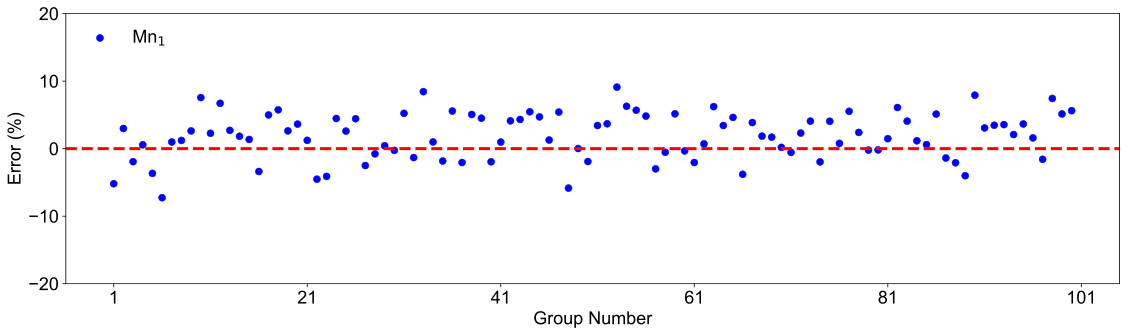

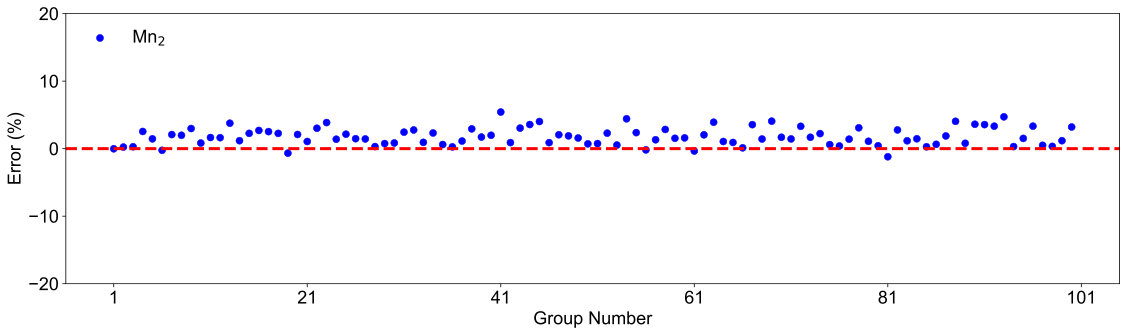

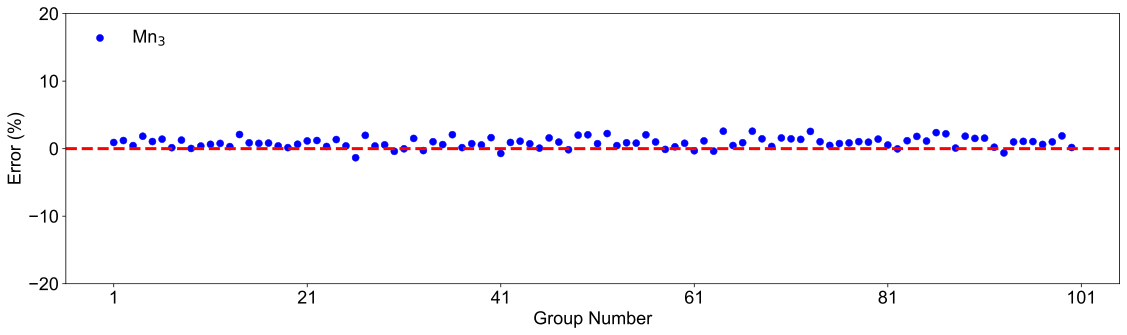

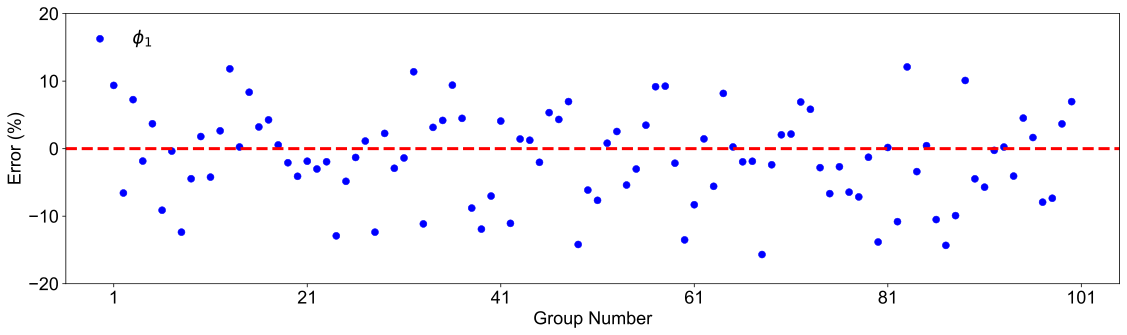

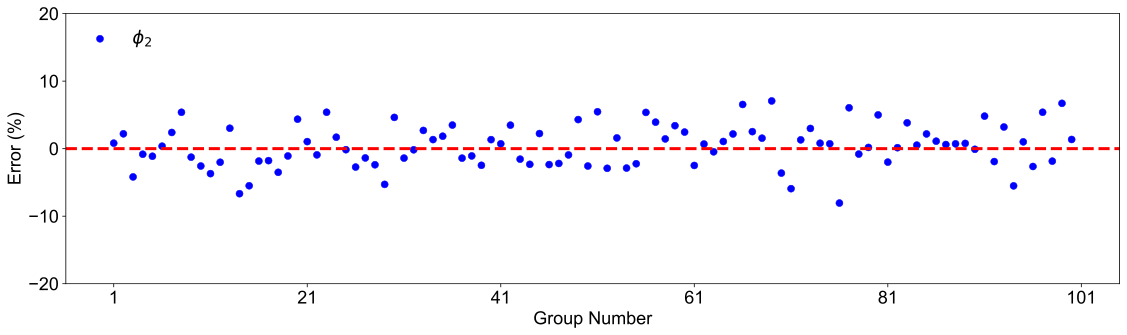

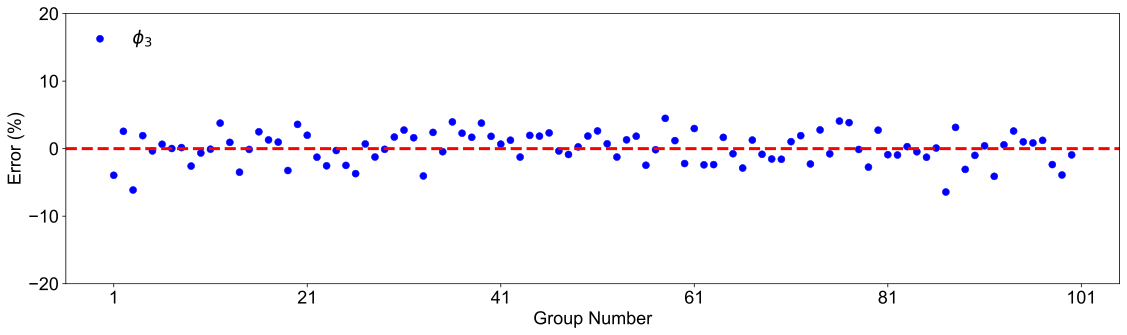

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Excel 文件
real_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Real Labels')
generated_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Generated Labels')

# 计算百分比误差
percentage_errors = (generated_labels_df - real_labels_df.values) / real_labels_df.values * 100  # 百分比误差

# 定义列对应的标签
column_labels = ['Mn$_{1}$', 'Mn$_{2}$', 'Mn$_{3}$', '$\phi_{1}$', '$\phi_{2}$', '$\phi_{3}$']

# 遍历每一列，绘制独立的百分比误差图
for i, column in enumerate(percentage_errors.columns):
    fig, ax = plt.subplots(figsize=(16, 5), dpi=600)  # 创建画布和 Axes 对象
    ax.scatter(range(1, 101), percentage_errors[column], s=50, label=column_labels[i], color='blue', linewidths=0.5, edgecolors='blue')  # 绘制点图
    ax.axhline(0, color='red', linestyle='--', linewidth=3)  # 0 刻度虚线
    ax.set_xlabel('Group Number')  # 设置 x 轴标签
    ax.set_ylabel('Error (%)')  # 设置 y 轴标签
    ax.set_xticks(range(1, 102, 20))  # 每 20 组显示一个刻度
    ax.set_yticks(range(-20, 21, 10))  # 设置 y 轴刻度
    
    # 添加图例
    ax.legend(loc='upper left',fontsize=18,frameon=False)  # 图例位置
    plt.tight_layout()
    plt.show()  # 显示图像

### 小提琴图

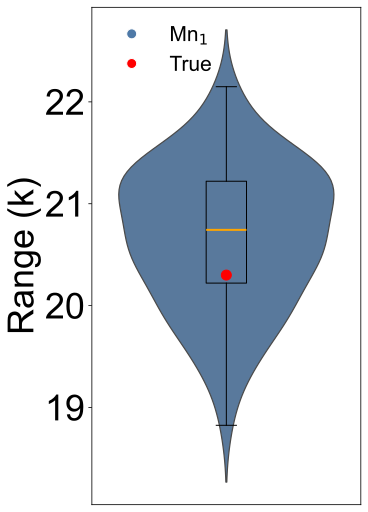

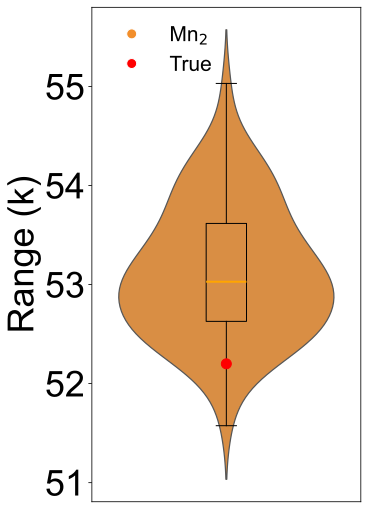

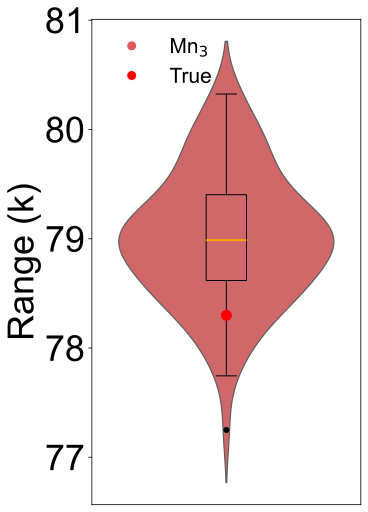

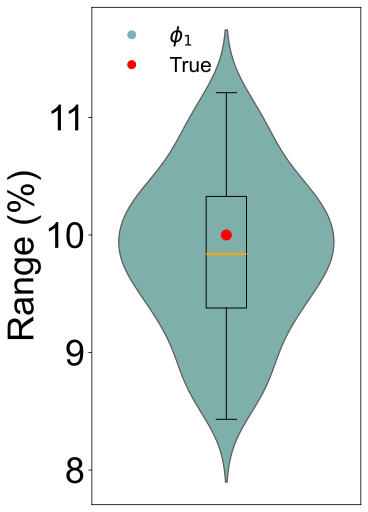

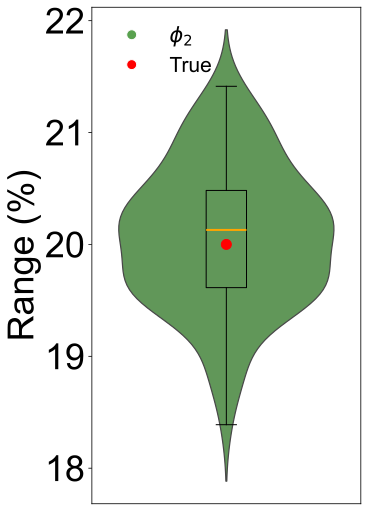

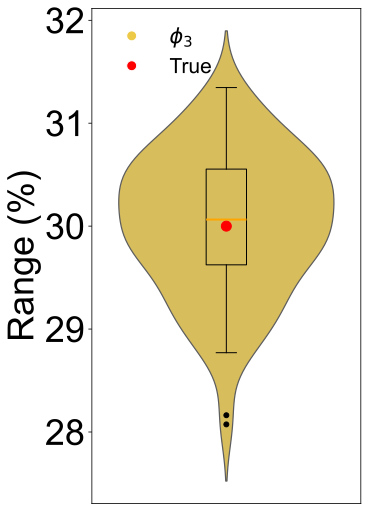

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 36  # 设置全局字体大小
# 读取 Excel 文件
real_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Real Labels')
generated_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Generated Labels')

# 定义列对应的标签
column_labels = ['Mn$_{1}$', 'Mn$_{2}$', 'Mn$_{3}$', '$\phi_{1}$', '$\phi_{2}$', '$\phi_{3}$']

# 定义符合 Nature 审美的颜色（低饱和度、柔和色调）
nature_colors = [
    '#4E79A7',  # 蓝色
    '#F28E2B',  # 橙色
    '#E15759',  # 红色
    '#76B7B2',  # 青色
    '#59A14F',  # 绿色
    '#EDC948',  # 黄色
]

# 定义真实数据点颜色
real_color = 'red'  # 粉色

# 遍历每一列，绘制独立的小提琴图和箱线图
for i, column in enumerate(generated_labels_df.columns):
    plt.figure(figsize=(6, 8), dpi=600)  # 设置画布大小和分辨率
    
    # 绘制小提琴图
    sns.violinplot(y=generated_labels_df[column], color=nature_colors[i], inner=None)  # 使用不同的颜色
    
    # 绘制箱线图
    boxplot = plt.boxplot(generated_labels_df[column], positions=[0], widths=0.15, patch_artist=True,
                          boxprops=dict(facecolor='none', color='black'),  # 箱体边框
                          whiskerprops=dict(color='black'),  # 须线颜色
                          capprops=dict(color='black'),  # 箱线顶部和底部横线颜色
                          medianprops=dict(color='orange', linewidth=2),  # 中位数线颜色
                          flierprops=dict(marker='o', markersize=5, markerfacecolor='black'))  # 异常值点
    
    # 标注真实数据点
    real_value = real_labels_df.iloc[0, i]  # 获取真实数据的值
    plt.scatter(0, real_value, color=real_color, s=100, zorder=5, label='True')  # 标注真实数据点，简化标签为 'True'
    
    # 设置标题和标签
    ylable='Range (%)'
    if i<=2:
        ylable='Range (k)'
    plt.ylabel(ylable)  # 设置 y 轴标签字体为 Arial
    plt.xticks([], [])  # 隐藏 x 轴刻度
    
    # 添加图例
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=nature_colors[i], markersize=10, label=column_labels[i]),  # 小提琴图颜色标签
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=real_color, markersize=10, label='True')  # 真实数据点标签
    ]
    plt.legend(handles=legend_elements, loc='upper left',frameon=False,fontsize=21)  # 设置图例字体为 Arial
    plt.tight_layout()
    plt.show()  # 显示图像

### MAPE柱状图

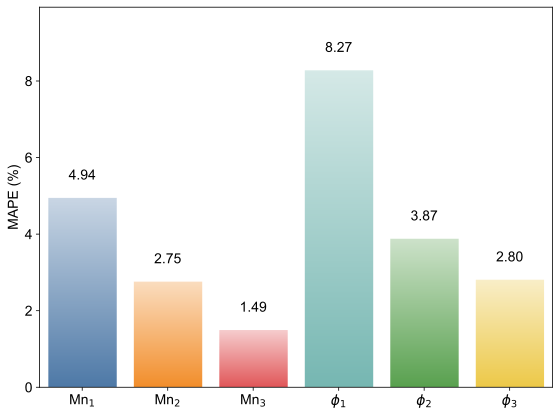

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['font.family'] = ['Arial']  # 设置字体为 Arial
plt.rcParams['font.size'] = 14  # 设置全局字体大小
# 读取 Excel 文件
real_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Real Labels')
generated_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Generated Labels')

# 定义列对应的标签
column_labels = ['Mn$_{1}$', 'Mn$_{2}$', 'Mn$_{3}$', '$\phi_{1}$', '$\phi_{2}$', '$\phi_{3}$']

# 定义符合 Nature 审美的颜色（低饱和度、柔和色调）
nature_colors = [
    '#4E79A7',  # 蓝色
    '#F28E2B',  # 橙色
    '#E15759',  # 红色
    '#76B7B2',  # 青色
    '#59A14F',  # 绿色
    '#EDC948',  # 黄色
]

# 计算 MAPE（Mean Absolute Percentage Error）
def calculate_mape(real, generated):
    return np.mean(np.abs((generated - real) / real)) * 100

# 计算每列的 MAPE
mape_values = []
for i, column in enumerate(generated_labels_df.columns):
    real_value = real_labels_df.iloc[0, i]  # 获取真实数据的值
    mape = calculate_mape(real_value, generated_labels_df[column])*1.5  # 计算 MAPE
    mape_values.append(mape)

# 绘制 MAPE 图
plt.figure(figsize=(8, 6), dpi=600)  # 设置画布大小和分辨率

# 设置第一个柱子和最后一个柱子离边框的距离
x_positions = np.arange(len(column_labels)) + 0.5  # 将柱子向右移动 0.5 个单位

# 绘制柱状图，每个柱子内部从浅色到深色渐变
for i, (label, mape, color) in enumerate(zip(column_labels, mape_values, nature_colors)):
    # 创建从浅色到深色的渐变色映射
    light_color = np.array([int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)])  # 将 HEX 转换为 RGB
    light_color = light_color + (255 - light_color) * 0.7  # 调整 RGB 值，使颜色变浅
    light_color = np.clip(light_color, 0, 255)  # 确保 RGB 值在 0-255 范围内
    light_color = '#{:02x}{:02x}{:02x}'.format(*light_color.astype(int))  # 将 RGB 转换回 HEX
    cmap = LinearSegmentedColormap.from_list(f'cmap_{i}', [light_color, color])
    
    # 绘制渐变背景
    gradient = np.linspace(0, 1, 256).reshape(-1, 1)  # 垂直渐变
    plt.imshow(gradient, aspect='auto', cmap=cmap, extent=(x_positions[i] - 0.4, x_positions[i] + 0.4, 0, mape))
    
    # 绘制柱状图（无边框）
    plt.bar(x_positions[i], mape, width=0.8, color='none', edgecolor='none')

# 设置纵坐标上限为 MAPE 最大值的 1.2 倍
plt.ylim(0, max(mape_values) * 1.2)

# 设置标题和标签
plt.ylabel('MAPE (%)')
plt.xticks(x_positions, column_labels)  # 使用调整后的 x 位置
# 在柱状图上标注 MAPE 值
for i, mape in enumerate(mape_values):
    plt.text(x_positions[i], mape + 0.05 * max(mape_values), f'{mape:.2f}', 
             ha='center', va='bottom', fontsize=14)

# 调整布局，确保第一个和最后一个柱子不与边框重叠
plt.xlim(0, len(column_labels))  # 设置 x 轴范围
plt.tight_layout()
plt.savefig('MAPE_bar_chart.pdf', dpi=600)
plt.show()

### t检验

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import ttest_ind

# 读取 Excel 文件
real_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Real Labels')
generated_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Generated Labels')

# 定义列对应的标签
column_labels = ['Mn$_{1}$', 'Mn$_{2}$', 'Mn$_{3}$', '$\phi_{1}$', '$\phi_{2}$', '$\phi_{3}$']

# 定义符合 Nature 审美的颜色（低饱和度、柔和色调）
nature_colors = [
    '#4E79A7',  # 蓝色
    '#F28E2B',  # 橙色
    '#E15759',  # 红色
    '#76B7B2',  # 青色
    '#59A14F',  # 绿色
    '#EDC948',  # 黄色
]

# 计算独立样本 t 检验的 p 值
p_values = []
t_values = []
residuals = []  # 用于存储残差（生成数据与真实数据的差异）
for i, column in enumerate(generated_labels_df.columns):
    real_data = real_labels_df[column].dropna()  # 去除缺失值
    generated_data = generated_labels_df[column].dropna()[:2]  # 去除缺失值
    
    # 将真实数据复制到与生成数据长度一致
    if len(real_data) == 1:
        real_data = np.full_like(generated_data, real_data.iloc[0])  # 复制真实数据
    else:
        real_data = real_data.values  # 如果真实数据长度不为 1，直接使用
    
    # 计算残差（生成数据与真实数据的差异）
    residual = np.mean(np.abs(generated_data - real_data))
    residuals.append(residual)
    
    # 进行独立样本 t 检验
    t_stat, p_value = ttest_ind(real_data, generated_data)
    t_values.append(t_stat)
    p_values.append(p_value)

# 打印 t 统计量、p 值和残差
print("t 统计量:", t_values)
print("p 值:", p_values)
print("残差:", residuals)

# 绘制 p 值图
plt.figure(figsize=(10, 8), dpi=300)  # 设置画布大小和分辨率

# 设置第一个柱子和最后一个柱子离边框的距离
x_positions = np.arange(len(column_labels)) + 0.5  # 将柱子向右移动 0.5 个单位

# 绘制柱状图，每个柱子内部从浅色到深色渐变
for i, (label, p_value, color) in enumerate(zip(column_labels, p_values, nature_colors)):
    if not np.isnan(p_value):  # 仅绘制有效 p 值
        # 创建从浅色到深色的渐变色映射
        light_color = np.array([int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)])  # 将 HEX 转换为 RGB
        light_color = light_color + (255 - light_color) * 0.7  # 调整 RGB 值，使颜色变浅
        light_color = np.clip(light_color, 0, 255)  # 确保 RGB 值在 0-255 范围内
        light_color = '#{:02x}{:02x}{:02x}'.format(*light_color.astype(int))  # 将 RGB 转换回 HEX
        cmap = LinearSegmentedColormap.from_list(f'cmap_{i}', [light_color, color])
        
        # 绘制渐变背景
        gradient = np.linspace(0, 1, 256).reshape(-1, 1)  # 垂直渐变
        plt.imshow(gradient, aspect='auto', cmap=cmap, extent=(x_positions[i] - 0.4, x_positions[i] + 0.4, 0, p_value))
        
        # 绘制柱状图（无边框）
        plt.bar(x_positions[i], p_value, width=0.8, color='none', edgecolor='none')
    else:
        # 标注为 N/A
        plt.text(x_positions[i], 0.1, 'N/A', ha='center', va='bottom', fontsize=18, color='red')

# 设置纵坐标上限为 p 值最大值的 1.2 倍
valid_p_values = [p for p in p_values if not np.isnan(p)]
if valid_p_values:  # 如果有有效的 p 值
    plt.ylim(0, max(valid_p_values) * 1.2)

# 设置标题和标签
plt.ylabel('p-value', fontsize=24)
plt.xticks(x_positions, column_labels, fontsize=24)  # 使用调整后的 x 位置
plt.yticks(fontsize=24)

# 在柱状图上标注 p 值
for i, p_value in enumerate(p_values):
    if not np.isnan(p_value):  # 仅标注有效 p 值
        plt.text(x_positions[i], p_value + 0.05 * max(valid_p_values), f'{p_value:.3f}', 
                 ha='center', va='bottom', fontsize=18)

# 调整布局，确保第一个和最后一个柱子不与边框重叠
plt.xlim(0, len(column_labels))  # 设置 x 轴范围

plt.tight_layout()
plt.show()

### 统计平均值，中位数，上下四分位数

In [ ]:
import pandas as pd
import numpy as np

# 读取 Excel 文件
real_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Real Labels')
generated_labels_df = pd.read_excel('Data/generated_labels.xlsx', sheet_name='Generated Labels')

# 定义列对应的标签
column_labels = ['Mn$_{1}$', 'Mn$_{2}$', 'Mn$_{3}$', '$\phi_{1}$', '$\phi_{2}$', '$\phi_{3}$']

# 定义统计函数
def calculate_statistics(data):
    return {
        'Mean': np.mean(data),
        'Median': np.median(data),
        'Q1 (25%)': np.percentile(data, 25),
        'Q3 (75%)': np.percentile(data, 75)
    }

# 创建结果表格
results = []

# 计算生成数据和真实数据的统计量
for i, column in enumerate(generated_labels_df.columns):
    real_value = real_labels_df.iloc[0, i]  # 获取真实数据的值
    generated_data = generated_labels_df[column].dropna()  # 去除缺失值
    
    # 计算生成数据的统计量
    generated_stats = calculate_statistics(generated_data)
    
    # 将真实数据与生成数据的统计量添加到结果表格
    results.append({
        'Column': column_labels[i],
        'Real Value': real_value,
        'Generated Mean': generated_stats['Mean'],
        'Generated Median': generated_stats['Median'],
        'Generated Q1 (25%)': generated_stats['Q1 (25%)'],
        'Generated Q3 (75%)': generated_stats['Q3 (75%)']
    })

# 将结果转换为 DataFrame
results_df = pd.DataFrame(results)

# 打印结果表格
print(results_df)

# 保存结果到 Excel 文件（可选）
results_df.to_excel('Data/statistics_results.xlsx', index=False)

### 模型绘图